In [1]:
# import libraries

import warnings
import itertools

import pandas as pd
import numpy as np
from scipy.integrate import quad
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# import data
df = pd.read_csv('TOTALNSA.csv', parse_dates=True, index_col='DATE', sep=',')
df.index.freq ='MS'
df.columns = ['y']

In [3]:
# check data shape
df.shape

(527, 1)

In [4]:
# check first 5 records
df.head()

,y
DATE,
1976-01-01,885.2
1976-02-01,994.7
1976-03-01,1243.6
1976-04-01,1191.2
1976-05-01,1203.2


In [5]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [6]:
# simple descriptive statistics
df.describe()

,y
count,527.0
mean,1261.7
std,225.6
min,670.5
25%,1109.1
50%,1270.6
75%,1429.3
max,1845.7


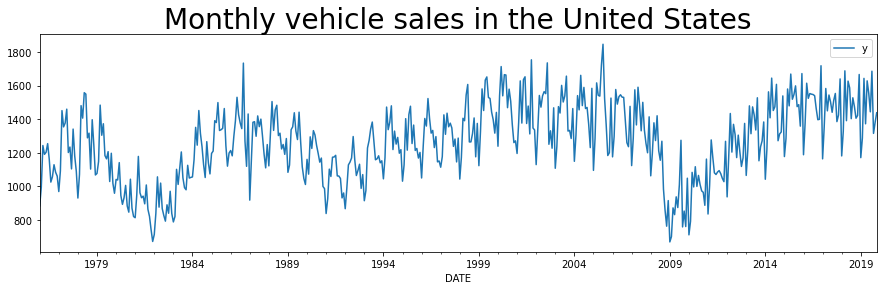

In [7]:
# plot the data by date

df.plot(figsize=(15, 4));
plt.title('Monthly vehicle sales in the United States', size=28);

In [8]:
# create additional column 'index_month'
df['index_month'] = df.index.month
df.head()

,y,index_month
DATE,,
1976-01-01,885.2,1
1976-02-01,994.7,2
1976-03-01,1243.6,3
1976-04-01,1191.2,4
1976-05-01,1203.2,5


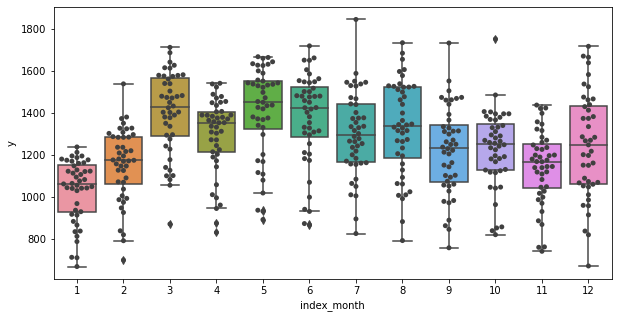

In [9]:
# create monthly box-plot
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="index_month", y="y", data=df)
ax = sns.swarmplot(x="index_month", y="y", data=df, color=".25")

In [10]:
# drop index_month column
df.drop('index_month', inplace=True, axis=1)

**Overall, the mean of the vehicle sales is trending upward with periodical drops.  
There is a strong seasonality trend.  
The average value or the mean of the residuals seem to be zero.**

<Figure size 432x288 with 0 Axes>

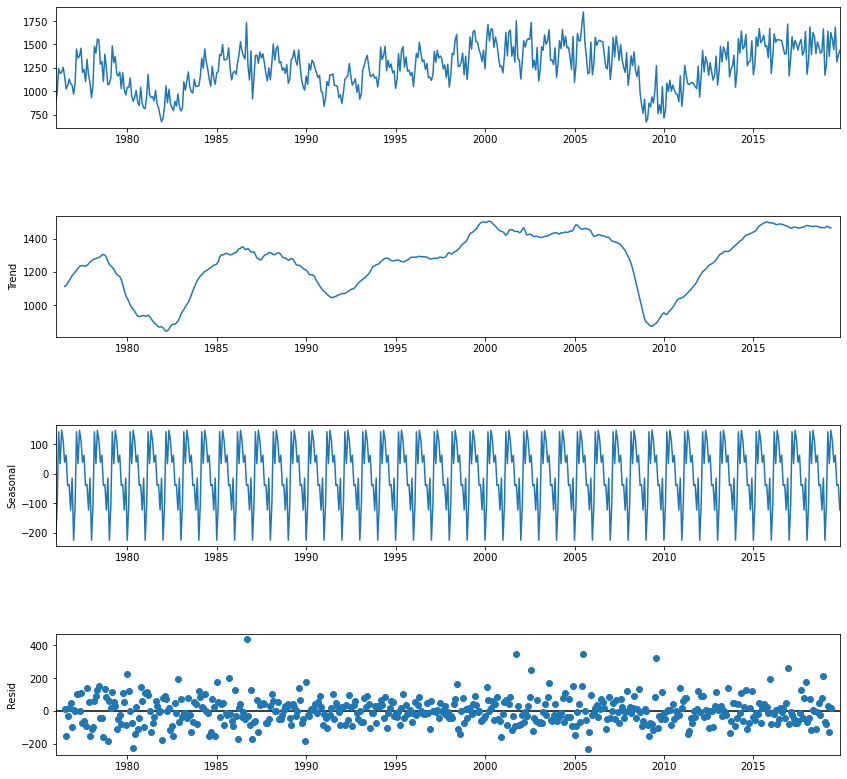

In [247]:
# decompose the data
decomposition = seasonal_decompose(df, period=12)
figure = plt.figure();
figure = decomposition.plot();  
figure.set_size_inches(13, 12);

**The data clearly have some seasonality, so we will first take a seasonal difference.**

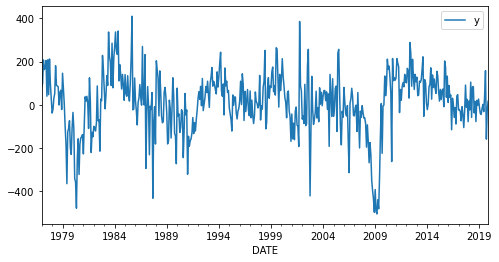

In [248]:
# take 12 month differences

diff_12 = (df - df.shift(12)).dropna()
diff_12.plot(figsize=(8, 4));

**The data after seasonal difference also appear to be non-stationary, so take an additional first difference.**

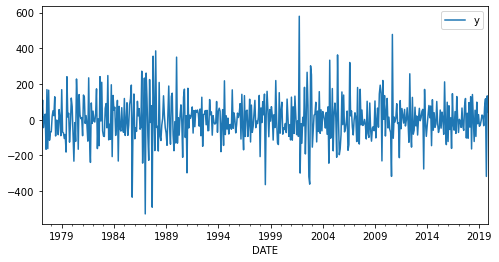

In [249]:
# take an additional first difference

diff_12_1 = (diff_12 - diff_12.shift(1)).dropna()
diff_12_1.plot(figsize=(8, 4));

**The data after seasonal difference appear to be stationary, use Dickey-Fuller test to check if data is stationary**

In [250]:
# Dickey-Fuller test

def check_adf(time_series):
    test_result = adfuller(time_series)
    print('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']
    for value,label in zip(test_result,labels):
        print(label+':'+str(value))
    if test_result[1] <= 0.05:
        print("Reject null hypothesis and data is stationary")
    else:
        print("fail to reject H0 and data is non-stationary ")
        
# check the autocorrelation after differencing
check_adf(diff_12_1)

ADF Test:
ADF Statistic:-8.364724233678796
p-value:2.762641643106331e-13
No. of Lags Used:12
Number of Observations Used:501
Reject null hypothesis and data is stationary


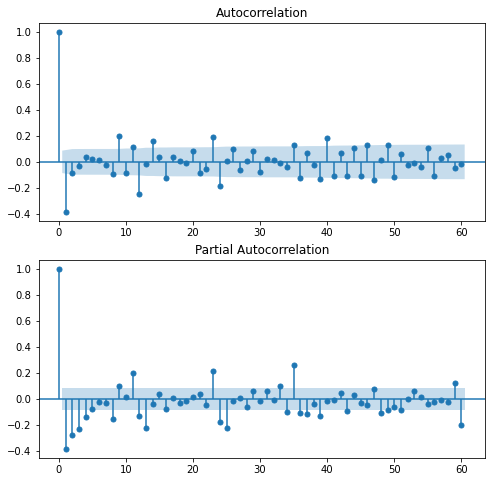

In [251]:
# use ACF and PACF to check the autocorrelation after differencing

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(diff_12_1, lags=60, ax=ax1)
plot_pacf(diff_12_1, lags=60, ax=ax2)
plt.show()

### Find an appropriate ARIMA model based on the ACF and PACF shown above

**The significant spike at lag 1 in the ACF suggests a non-seasonal MA(1) component, and the significant spike at lag 12 in the ACF suggests a seasonal MA(1) component.  
The significant spike at lag 1,2,3,4 in the PACF suggests a non-seasonal AR(4) component, and the significant spike at lag 12 in the PACF suggests a seasonal AR(1) component.  
I will begin with an `ARIMA(4,1,1)(1,1,1)12` model, indicating a first difference and a seasonal difference, non-seasonal MA(1) component and seasonal MA(1) component, and non-seasonal AR(4) component and seasonal AR(1) component.**

In [252]:
# fit model
model = sm.tsa.statespace.SARIMAX(df,order=(4,1,1), seasonal_order=(1,1,1,12))
ARIMAresult = model.fit(maxiter=100)
print(ARIMAresult.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  527
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3053.730
Date:                            Mon, 19 Oct 2020   AIC                           6123.460
Time:                                    06:41:41   BIC                           6157.398
Sample:                                01-01-1976   HQIC                          6136.762
                                     - 11-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3982      0.035     11.448      0.000       0.330       0.466
ar.L2          0.1534      0.044   

**Check model assumptions about whether residues are normally distributed.  
Diagnostic plots show the residues seem to be normally distributed.**

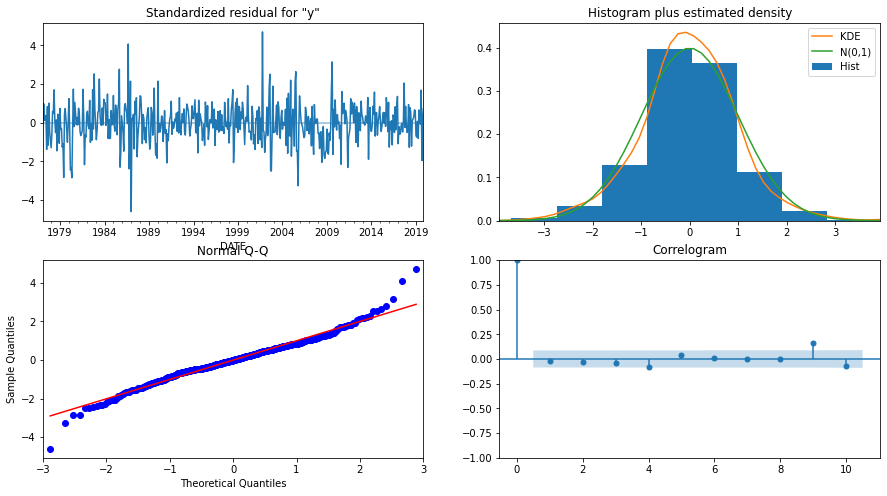

In [253]:
ARIMAresult.plot_diagnostics(figsize=(15, 8))
plt.show()

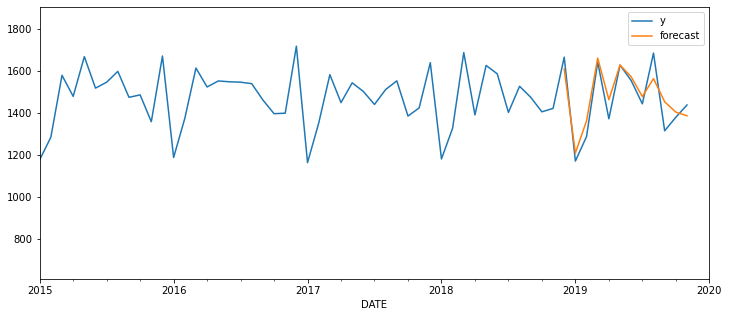

In [254]:
# predict sales of the last 12 months to visually check prediction error

df['forecast'] = ARIMAresult.predict(start = 515, end= 527, dynamic= True, full_results=True)  
df.plot(figsize= (12,5));
plt.xlim('2015-01-01', '2020-01-01');

In [255]:
# calculate MAE and MAPE, check how model performs for 12 month period

mae = mean_absolute_error(df['y'][-12:], df['forecast'][-12:])
mape = mae/(df['y'][-12:]).mean()*100

print('MAE - mean absolute error is {}'.format(round(mae, 1)))
print('MAPE - mean absolute percentage error is {}%'.format(round(mape, 1)))

MAE - mean absolute error is 55.6
MAPE - mean absolute percentage error is 3.8%


#### For a prediction of previous 12 months, the MAPE is only 3.8%, suggesting the model is good.

In [256]:
# forecast sales for the next 13 months

fcast = ARIMAresult.get_forecast(13).summary_frame(alpha=0.1)
fcast

y,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-12-01,1625.8,90.7,1476.6,1774.9
2020-01-01,1177.9,97.7,1017.2,1338.6
2020-02-01,1331.2,101.8,1163.7,1498.6
2020-03-01,1641.9,107.4,1465.2,1818.5
2020-04-01,1439.6,114.5,1251.2,1628.0
2020-05-01,1619.8,119.1,1423.9,1815.7
2020-06-01,1554.4,122.9,1352.2,1756.7
2020-07-01,1479.8,126.7,1271.5,1688.2
2020-08-01,1619.0,130.1,1405.0,1833.0
2020-09-01,1385.2,133.0,1166.4,1604.0


In [257]:
# 2019 total sales (first 11 months actual sales plus December forecast sales)
sales_2019 = (df['y'][-11:].sum() + fcast['mean'][:1]).values[0]

# 2020 total sales from forecast
forecast_2020 = fcast['mean'][1:].sum()

print('Sales in 2019 --- {}'.format(sales_2019))
print('Sales in 2020 --- {}'.format(forecast_2020))

Sales in 2019 --- 17547.34964864189
Sales in 2020 --- 17633.760232204455


### Assume --- ACME represents 1% of the total sales again in 2020

In [258]:
# calculate ACME sales in 2019 and 2020

ACME_2019 = sales_2019 * 0.01
ACME_2020 = forecast_2020 * 0.01
print('ACME sales in 2019 --- {}'.format(ACME_2019))
print('ACME sales in 2020 --- {}'.format(ACME_2020))

ACME sales in 2019 --- 175.47349648641892
ACME sales in 2020 --- 176.33760232204455


In [259]:
increase = round((ACME_2020 - ACME_2019)/ACME_2019 * 100 , 2)
increase

0.49

**Percentage increase of 2020 forecast sales compared to 2019 is only 0.49%. I would suggest add only 0.5% more staff.**